In [1]:
import os
import sys
import cv2
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
import pandas as pd

sys.path.append('../../')
from src.data.generator.keypoint.Keypoint import _KeypointDataset
from src.data.transforms import build_transforms
from src.data.generator.keypoint.target_generators import HeatmapGenerator, ScaleAwareHeatmapGenerator
from src.data.generator.keypoint.target_generators import JointsGenerator

In [2]:
from hydra.experimental import initialize, compose
from omegaconf import OmegaConf

initialize(config_path="../../configs")
cfg=compose(config_name="train.yaml")

/home/magata/.pyenv/versions/3.6.5/envs/basemodel/lib/python3.6/site-packages/omegaconf/omegaconf.py:579: UserWarning: update() merge flag is is not specified, defaulting to False.
For more details, see https://github.com/omry/omegaconf/issues/367
  stacklevel=1,


In [3]:
class DemoKeypoints(_KeypointDataset):
    """
    """
    def __init__(self, cfg, path_split, is_train, heatmap_generator, joints_generator, transforms=None, fold=None):
        super().__init__(cfg, path_split, is_train, heatmap_generator, joints_generator, transforms, fold)
        
        if cfg.DATA.WITH_CENTER:
            assert cfg.MODEL.NUM_JOINTS == 17, 'Number of joint with center for Hand is 22'
        else:
            assert cfg.MODEL.NUM_JOINTS == 16, 'Number of joint for Hand is 21'
            
    def __len__(self):
        return len(self.df)
    
    def get_data(self, index):
        img = imread(self.df.image_path.iloc[index])
        joints = self.get_joints(index)
        mask = np.ones((img.shape[0], img.shape[1]))
        return img, joints, mask
    
    def get_joints(self, index):
        #parse
        joints = self.df.joints.iloc[index].copy()
        #学習時にはx,yのオーダーで渡す必要あり、要fix
        joints[...,:2] = joints[...,:2][...,::-1]
        return joints

In [4]:
csv_path = '../../data/demo_keypoint/split/demo_trainval.pkl'
is_train = True
fold = 1

heatmap_generator = [HeatmapGenerator(output_size, cfg.MODEL.NUM_JOINTS, cfg.DATA.SIGMA)
                     for output_size in cfg.MODEL.OUTPUT_SIZE]

joints_generator = [JointsGenerator(cfg.DATA.MAX_NUM_PEOPLE, cfg.MODEL.NUM_JOINTS, output_size, cfg.MODEL.TAG_PER_JOINT)
                    for output_size in cfg.MODEL.OUTPUT_SIZE]

transforms = build_transforms(cfg, is_train)

In [5]:
train_dataset = DemoKeypoints(cfg, csv_path, is_train, heatmap_generator, joints_generator, transforms, fold=fold)

### Transform(Augmentation, Normalization)前

In [6]:
idx = 0
img, joints, mask = train_dataset.get_data(idx)

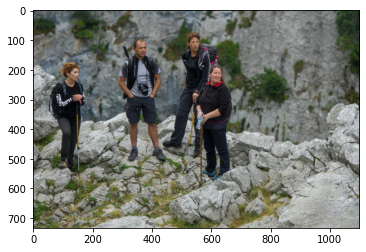

In [7]:
plt.imshow(img)

### Transform(Augmentation, Normalization)後

In [8]:
img, target_list, mask_list, joints_list = train_dataset.__getitem__(idx)

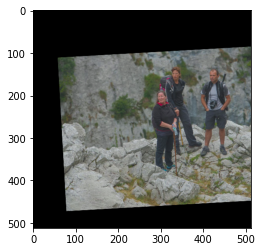

In [9]:
img_re = np.asarray(img) * np.array([0.229, 0.224, 0.225]).reshape(-1,1,1) + np.array([0.485, 0.456, 0.406]).reshape(-1,1,1)
plt.imshow((img_re*255).astype(np.uint8).transpose(1,2,0))

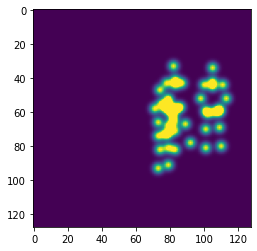

In [21]:
plt.imshow(np.sum(target_list[0], axis=0), vmax=1)

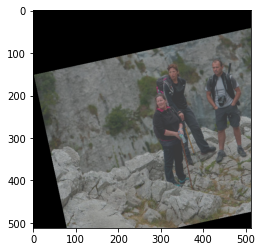

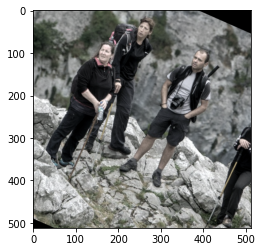

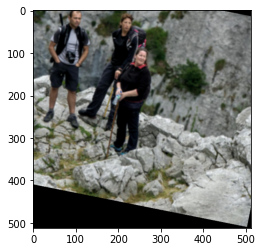

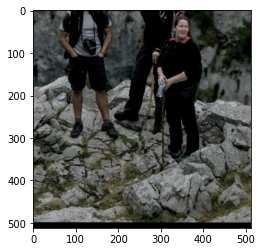

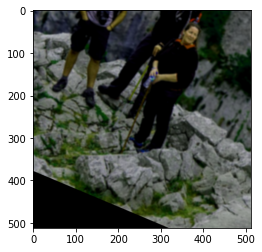

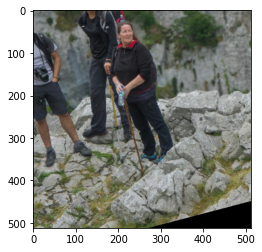

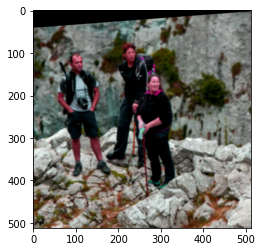

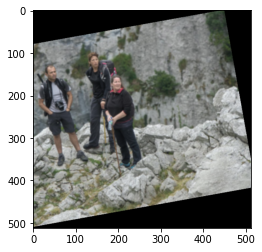

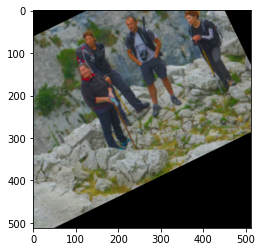

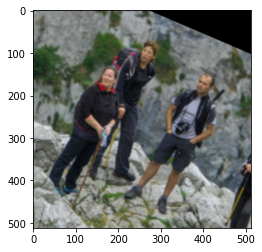

In [22]:
for i in range(10):
    img, target_list, mask_list, joints_list = train_dataset.__getitem__(idx)
    img_re = np.asarray(img) * np.array([0.229, 0.224, 0.225]).reshape(-1,1,1) + np.array([0.485, 0.456, 0.406]).reshape(-1,1,1)
    plt.imshow((img_re*255).astype(np.uint8).transpose(1,2,0))
    plt.show()